In [1]:
import math
import time
from itertools import chain

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# from keras.losses import MSE
from numpy import concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm

device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")
print(device)

ModuleNotFoundError: No module named 'keras'

In [18]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional).to(device)
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes).to(device)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_directions *
                                   self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_directions *
                                   self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0.to(device), c_0.to(device)))
        pred = self.fc(ula)
        pred = pred[:, -1, :]
        # h_out = h_out.view(-1, self.hidden_size)
        # out = self.fc(h_out)
        return pred


file_number = '63000600'
file_type = 'st_dayev_r'

def load_data():
    rawdata = pd.read_csv(f'data/groupByCZ/{file_number}{file_type}.csv')
    # rawdata.columns = ['', 'RCD', 'TM', 'INTV', 'DRP', 'MODITIME', 'SOURCE']
    rawdata = rawdata.drop(columns='RCD')
    # rawdata = rawdata.drop(columns='TM')
    rawdata = rawdata.loc[:, ~rawdata.columns.str.contains('^Unnamed')]
    # rawdata.fillna(rawdata.mean(), inplace=True)
    rawdata.fillna(0, inplace=True)
    rawdata.DRP = rawdata.DRP.astype("float32")
    return rawdata


def strlist_to_date(s):
    def is_run(yyyy):
        if yyyy % 400 == 0:
            return 1
        if yyyy % 4 == 0 and yyyy % 100 != 0:
            return 1
        return 0

    res = []
    for i in s:
        yyyy = int(i[:4])
        mm = int(i[5:7])
        dd = int(i[8:10])
        month = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
        day = month[mm - 1] + dd + (is_run(yyyy) if mm >= 2 else 0)
        res.append(day)
    return res


def rainfall_to_level(pp):
    res = []
    for i in pp:
        res.append(1 if i <= 1 else (
            2 if i <= 10 else (3 if i <= 25 else (4 if i <= 50 else (5 if i <= 100 else (6 if i <= 250 else 7))))))
    return res


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

(24463, 7, 1) (24463, 1)
torch.Size([17124, 7, 1])
torch.Size([17124, 1])


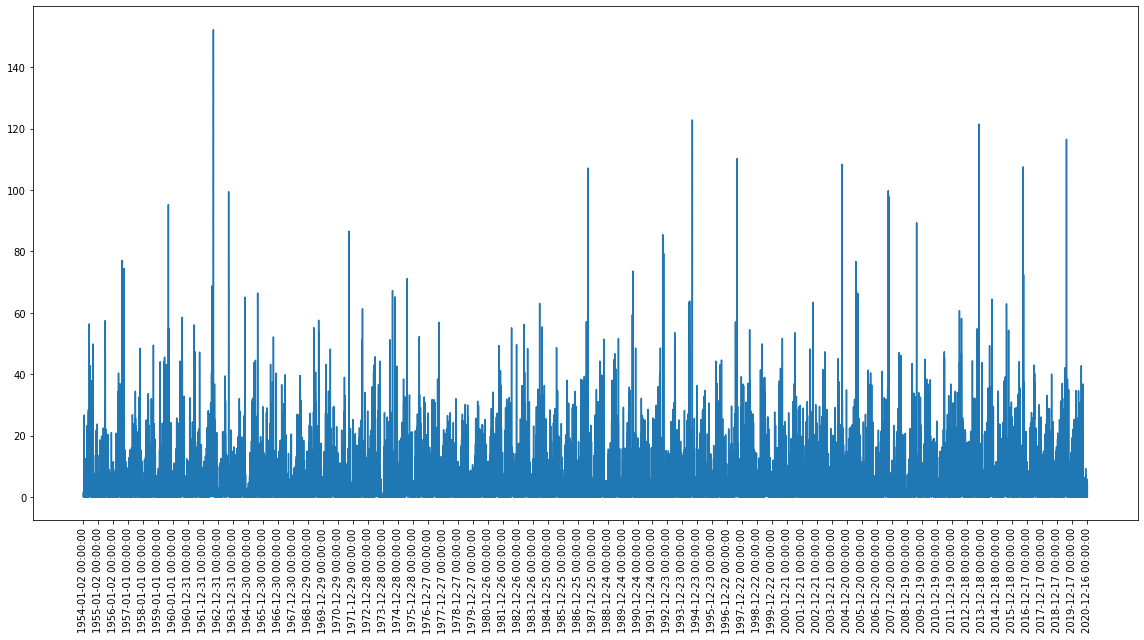

In [19]:
data_Normalize = False
dataset = load_data()
# print(dataset)
if data_Normalize:
    dataset.DRP = rainfall_to_level(dataset.DRP.values)
plt.figure(figsize=(16, 9))
plt.plot(dataset['DRP'])
plt.xticks(range(0, dataset.shape[0], 365), dataset['TM'].loc[::365], rotation=90)
plt.tight_layout()
plt.savefig(f'data/img/{file}MYL.jpg')
dataset = dataset.drop(columns='TM')
# dataset = dataset.drop(columns='INTV')
# dataset = dataset.drop(columns='MODITIME')
# dataset = dataset.drop(columns='SOURCE')

# dataset.TM = strlist_to_date(dataset.TM.values)
# print(dataset)
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

seq_len = 7
x, y = sliding_windows(dataset, seq_len)

print(x.shape, y.shape)
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))).to(device)
dataY = Variable(torch.Tensor(np.array(y)).cuda()).to(device)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(device)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(device)
print(trainX.shape)
print(trainY.shape)

Epoch: 0, loss: 0.11328
Epoch: 100, loss: 0.00264
Epoch: 200, loss: 0.00252
Epoch: 300, loss: 0.00248
Epoch: 400, loss: 0.00244
Epoch: 500, loss: 0.00240
Epoch: 600, loss: 0.00238
Epoch: 700, loss: 0.00235
Epoch: 800, loss: 0.00234
Epoch: 900, loss: 0.00232
Epoch: 1000, loss: 0.00231
Epoch: 1100, loss: 0.00230
Epoch: 1200, loss: 0.00229
Epoch: 1300, loss: 0.00229
Epoch: 1400, loss: 0.00228
Epoch: 1500, loss: 0.00227
Epoch: 1600, loss: 0.00227
Epoch: 1700, loss: 0.00226
Epoch: 1800, loss: 0.00226
Epoch: 1900, loss: 0.00225
Epoch: 2000, loss: 0.00225
Epoch: 2100, loss: 0.00224
Epoch: 2200, loss: 0.00224
Epoch: 2300, loss: 0.00224
Epoch: 2400, loss: 0.00223
Epoch: 2500, loss: 0.00223
Epoch: 2600, loss: 0.00222
Epoch: 2700, loss: 0.00222
Epoch: 2800, loss: 0.00222
Epoch: 2900, loss: 0.00221
Epoch: 3000, loss: 0.00221
Epoch: 3100, loss: 0.00221
Epoch: 3200, loss: 0.00220
Epoch: 3300, loss: 0.00220
Epoch: 3400, loss: 0.00220
Epoch: 3500, loss: 0.00219
Epoch: 3600, loss: 0.00219
Epoch: 3700, 

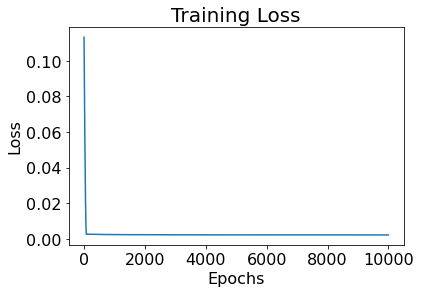

In [20]:
input_size = 1
hidden_size = 7
num_layers = 1
output_size = 1
epochs = 10000
is_bidirection = False
model = LSTM(input_size, hidden_size, num_layers, output_size, is_bidirection).to(device)
PATH = f'data/model/model{model.__class__}_file{file}_seq{seq_len}_Normalize{data_Normalize}.pt'

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training
start = time.time()
train_loss = []
mn = 1e9 + 7
for epoch in range(epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    # print(outputs.shape)
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if loss.item() < mn:
        mn = loss.item()
        torch.save(model, PATH)
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    train_loss.append(loss.item())
print('Time Used:', time.time() - start)

# plt.figure(figsize=(16, 9))
plt.plot(range(len(train_loss)), train_loss)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss', fontsize=20)
plt.show()